In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from beakerx import *
from tqdm import tnrange, tqdm_notebook

### helper functions

In [2]:
def groupby_percent(df, groupby_var, unit_var, figsize=(10, 5)):
    x = df.groupby(groupby_var).count().reset_index()
    x['percent'] = 100*x[unit_var]/df.shape[0]
    x = x.sort_values(['percent'])

    s = pd.DataFrame(x[[groupby_var, unit_var,'percent']])

    return(s, x.plot(x=groupby_var, y='percent', kind='barh', figsize=figsize, color='#2B8CC4'))

### Import data

In [3]:
DATADIR = os.path.join(os.getenv("DATA_DIR"), 'processed_journey')
DATADIR

'/Volumes/GoogleDrive/Team Drives/GOV.UK teams/2018-2019/Q3/Knowledge up Q3/Data science/data/processed_journey'

In [4]:
dlo = pd.read_csv(os.path.join(DATADIR, "dlo_prelim_meta_standard_with_pageseq_from_29-10_to_01-11-2018.csv.gz"), compression='gzip')
kloo = pd.read_csv(os.path.join(DATADIR, "kloo_prelim_meta_standard_with_pageseq_from_29-10_to_01-11-2018.csv.gz"), compression='gzip')

In [5]:
print(dlo.shape, kloo.shape)

(3788851, 15) (890977, 15)


### Sample data for speed

In [6]:
journeys = pd.concat([dlo.sample(frac=0.01, random_state=1234, weights=dlo.Occurrences).copy(), kloo.sample(frac=0.01, random_state=1234, weights=kloo.Occurrences).copy()], ignore_index=True)

In [7]:
journeys.shape

(46799, 15)

In [8]:
journeys['Occurrences'].describe()

count     46799.000000
mean        149.196179
std        3023.963701
min           1.000000
25%           1.000000
50%           1.000000
75%          12.000000
max      362010.000000
Name: Occurrences, dtype: float64

### derive variables (create features...)

In [9]:
journeys['page_list_eval'] = journeys['Page_List'].map(pd.eval)
journeys['page_seq_len'] = journeys['page_list_eval'].map(len)

In [10]:
journeys['page_list_NL_eval'] = journeys['Page_List_NL'].map(pd.eval)
journeys['page_seq_len_NL'] = journeys['page_list_NL_eval'].map(len)

In [11]:
# def contains_search(Page_List):
#     search_in_sequence = 0
#     thelist  = pd.eval(Page_List)
    
#     for page in thelist:
#         if ('/search?' in page) or ('/search/' in page):
#             search_in_sequence = 1
            
#     return search_in_sequence

# def count_search(Page_List):
#     times_search_in_sequence = 0
#     thelist  = pd.eval(Page_List)
    
#     for page in thelist:
#         if ('/search?' in page) or ('/search/' in page):
#             times_search_in_sequence += 1
#     return times_search_in_sequence


# # journeys['contains_search'] = list(map(contains_search, journeys['Page_List']))

# journeys['count_search'] = list(map(count_search, journeys['Page_List']))

In [12]:
journeys['count_search'] = journeys.PageSequence.str.count("/search?")+journeys.PageSequence.str.count("/search/")

In [13]:
journeys['event_list_contains_start'] = np.where(journeys.Event_List.str.contains("start"), 1, 0)
journeys['page_seq_contains_start'] = np.where(journeys.Sequence.str.contains("start"), 1, 0)
journeys['page_seq_contains_service.gov.uk'] = np.where(journeys.Sequence.str.contains("service.gov.uk"), 1, 0)

In [14]:
journeys['contains_search_regex'] = np.where((journeys.PageSequence.str.contains("/search?")) | (journeys.PageSequence.str.contains("/search/")), 1, 0)

Get differnet results when using the contains_search function iterating over pagelist to the regex function in PageSequence. It would be good to understand why. 

In [15]:
journeys['contains_search_n'] = journeys['contains_search_regex']*journeys['Page_Seq_Occurrences']

In [16]:
def get_end_page(Page_List):          
    return pd.eval(Page_List)[-1]

journeys['final_page'] = journeys['Page_List'].map(get_end_page)

In [17]:
def get_end_page_event(Page_Event_List):          
    return pd.eval(Page_Event_List)[-1][-1]

journeys['final_interaction'] = journeys['Page_Event_List'].map(get_end_page_event)

In [18]:
def count_desktop(DeviceCategories): 
    thelist  = pd.eval(DeviceCategories)
    desktop = 0
    mobile = 0
    other = 0
    for i in range(len(thelist)):
        if thelist[i][0] =='desktop':
            desktop = thelist[i][1]
        elif thelist[i][0] =='mobile':
            mobile = thelist[i][1]
        else:
            other = thelist[i][1]      
    return desktop, mobile, other

### Device used

In [19]:
journeys['desktop'], journeys['mobile'], journeys['other_device'] = zip(*journeys['DeviceCategories'].map(count_desktop))

In [20]:
journeys['more_desktop'] = np.where(journeys['desktop'] > (journeys['mobile']+journeys['other_device']), 1, 0)

more_desktop
0    21944
1    24855
dtype: int64


<Figure size 2160x2160 with 0 Axes>

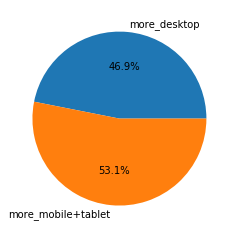

<Figure size 2160x2160 with 0 Axes>

In [21]:
print(journeys.groupby('more_desktop').size())
plt.pie(journeys.groupby('more_desktop').size(), labels=['more_desktop', 'more_mobile+tablet'], autopct='%1.1f%%')
plt.figure(figsize=(30,30))

### journey length 


EEK, be careful of frequency counts because need to include Occurences column for this. This is harder to interpret than it looks

In [22]:
journeys['page_seq_len'].describe()

count    46799.000000
mean         4.617535
std          6.036325
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        253.000000
Name: page_seq_len, dtype: float64

### Make a long df a row for each session

In [23]:
#make a smaller copy of data with only 2 cols ready to make it really looooong
slim = journeys[['Occurrences','final_page','page_seq_len', 'page_seq_len_NL', 'event_list_contains_start', 'count_search', 'contains_search_regex', 'page_list_NL_eval', 'Page_Seq_NL', 'page_seq_contains_start', 'page_seq_contains_service.gov.uk']].copy()
#repeat rows for each occurrence
journey_expanded =  slim.loc[slim.index.repeat(slim['Occurrences'])].copy()


In [24]:
journey_expanded.shape

(6982232, 11)

In [25]:
journey_expanded['page_seq_len'].describe()

count    6.982232e+06
mean     1.337045e+00
std      9.830142e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.530000e+02
Name: page_seq_len, dtype: float64

In [26]:
journey_expanded['page_seq_len_NL'].describe()

count    6.982232e+06
mean     1.273315e+00
std      9.111820e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.120000e+02
Name: page_seq_len_NL, dtype: float64

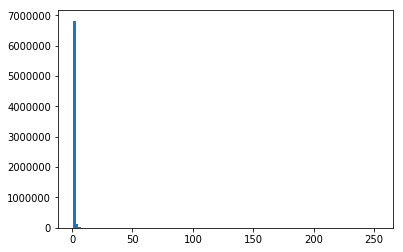

In [27]:
journey_expanded['page_seq_len'].hist(bins=122, grid=False)

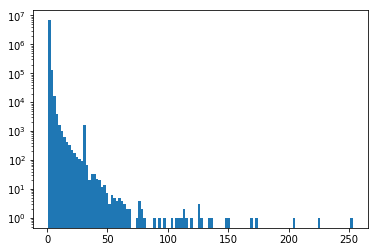

In [28]:
ax = journey_expanded['page_seq_len'].hist(bins=122, grid=False)
ax.set_yscale('log')

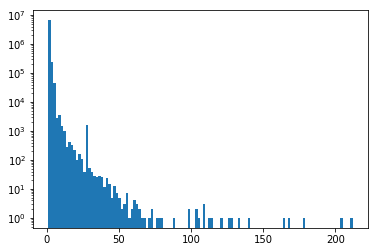

In [29]:
ax = journey_expanded['page_seq_len_NL'].hist(bins=122, grid=False)
ax.set_yscale('log')

### Search counts

In [30]:
print("{}/{} ({}%) of journeys contain internal search in their path".format(journeys['contains_search_n'].sum(),
                                                                             journeys['Page_Seq_Occurrences'].sum(),
                                                                             journeys['contains_search_n'].sum()/journeys['Page_Seq_Occurrences'].sum()*100))

786118/340084927 (0.23115343774115574%) of journeys contain internal search in their path


In [31]:
data = []
for i in range(journeys['page_seq_len'].max()):
    df = journeys[journeys['page_seq_len']==i]
    if df['Page_Seq_Occurrences'].sum()>1:
            percent = round(df['contains_search_n'].sum()/df['Page_Seq_Occurrences'].sum()*100, 1)
            n = df['contains_search_n'].sum()
            denom = df['Page_Seq_Occurrences'].sum()
            p = percent/100
            variance = (p*(1-p))/denom
            data.append([i+1, n, denom, percent, variance])

search_seqlength = pd.DataFrame(data, columns=['length', 'n', 'denom','percent', 'variance'])

In [112]:
search_seqlength.head()

,length,n,denom,percent,variance
0,2,264149,304589709,0.1,3.279822e-12
1,3,415961,31286493,1.3,4.101131e-10
2,4,92285,2353912,3.9,1.592201e-08
3,5,9318,1231221,0.8,6.445634e-09
4,6,1703,515145,0.3,5.806132e-09


In [33]:
search_seqlength['length'].describe()

count     66.000000
mean      36.606061
std       24.297438
min        2.000000
25%       18.250000
50%       34.500000
75%       50.750000
max      126.000000
Name: length, dtype: float64

Text(0, 0.5, 'Percent of journeys used internal search')

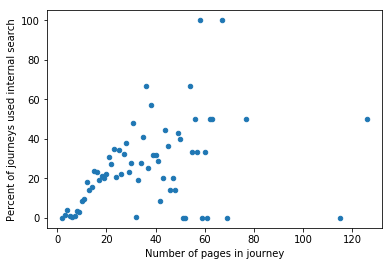

In [34]:
ax = search_seqlength.plot.scatter(x='length', y='percent')
ax.set_xlabel("Number of pages in journey")
ax.set_ylabel("Percent of journeys used internal search")

Text(0, 0.5, 'Percent of journeys used internal search')

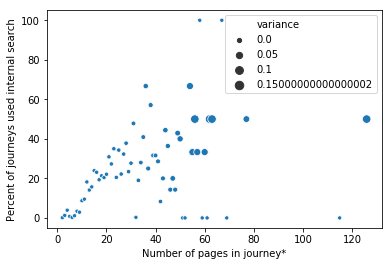

In [113]:
ax = sns.scatterplot(x="length", y="percent", size="variance", data=search_seqlength)
ax.set_xlabel("Number of pages in journey*")
ax.set_ylabel("Percent of journeys used internal search")

In [36]:
longerthan3 = journeys[journeys['page_seq_len']>3]

print("{}/{} ({}%) of longerthan3 contain internal search in their path".format(longerthan3['contains_search_n'].sum(),
                                                                             longerthan3['Page_Seq_Occurrences'].sum(),
                                                                             longerthan3['contains_search_n'].sum()/longerthan3['Page_Seq_Occurrences'].sum()*100))

13723/1854813 (0.7398589507405868%) of longerthan3 contain internal search in their path


In [37]:
journeys[journeys['contains_search_regex']==1].page_seq_len.describe()

count    4159.000000
mean        8.254869
std         8.936792
min         1.000000
25%         3.000000
50%         6.000000
75%        10.000000
max       173.000000
Name: page_seq_len, dtype: float64

In [38]:
journeys.page_seq_len.describe()

count    46799.000000
mean         4.617535
std          6.036325
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        253.000000
Name: page_seq_len, dtype: float64

In [39]:
journeys['count_search'].describe()

count    46799.000000
mean         0.176478
std          0.850652
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         45.000000
Name: count_search, dtype: float64

In [40]:
journeys[journeys['contains_search_regex']==1].count_search.describe()

count    4159.000000
mean        1.985814
std         2.133144
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        45.000000
Name: count_search, dtype: float64

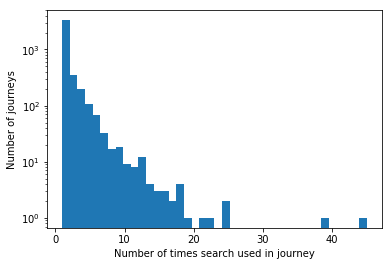

In [41]:
ax = journeys[journeys['contains_search_regex']==1].count_search.hist(bins=40, grid=False)
ax.set_xlabel("Number of times search used in journey")
ax.set_ylabel("Number of journeys")
ax.set_yscale('log')

(0, 10)

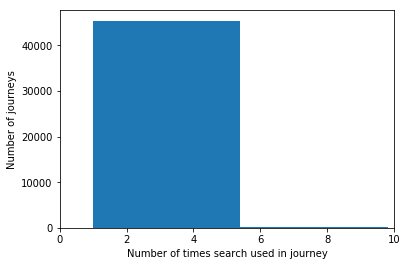

In [42]:
ax = journey_expanded[journey_expanded['contains_search_regex']==1].count_search.hist(bins=10, grid=False)
ax.set_xlabel("Number of times search used in journey")
ax.set_ylabel("Number of journeys")
ax.set_xlim(0, 10)

(0, 10)

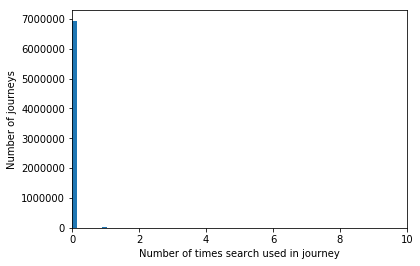

In [43]:
ax = journey_expanded.count_search.hist(bins=300, grid=False)
ax.set_xlabel("Number of times search used in journey")
ax.set_ylabel("Number of journeys")
ax.set_xlim(0, 10)

(0, 312)

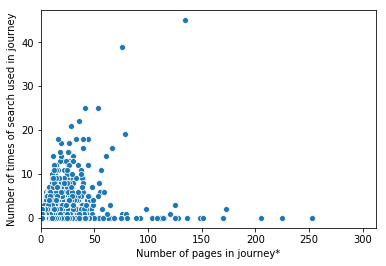

In [44]:
ax = sns.scatterplot(x="page_seq_len", y="count_search", data=journey_expanded)
ax.set_xlabel("Number of pages in journey*")
ax.set_ylabel("Number of times of search used in journey")
ax.set_xlim(0, 312)

In [45]:
# f, ax = plt.subplots(figsize=(6, 6))
# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
# sns.kdeplot(journey_expanded.page_seq_len, journey_expanded.count_search, cmap=cmap, n_levels=1000, shade=True)
# ax.set_xlim(0, 100)
# ax.set_ylim(0, 10)

In [46]:
# f, ax = plt.subplots(figsize=(6, 6))
# sns.kdeplot(journey_expanded.page_seq_len, journey_expanded.count_search, ax=ax)
# sns.rugplot(journey_expanded.page_seq_len, color="g", ax=ax)
# sns.rugplot(journey_expanded.count_search, vertical=True, ax=ax)


In [47]:
# with sns.axes_style("white"):
#     sns.jointplot(x=journey_expanded.page_seq_len, y=journey_expanded.count_search, kind="hex", color="k")

In [48]:
longerthan10 = journey_expanded[journey_expanded['page_seq_len']>10]

(0, 100)

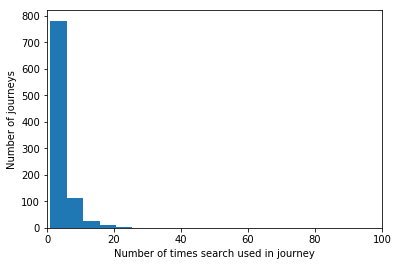

In [49]:
ax = longerthan10[longerthan10['contains_search_regex']==1].count_search.hist(bins=9, grid=False)
ax.set_xlabel("Number of times search used in journey")
ax.set_ylabel("Number of journeys")
ax.set_xlim(0, 100)

In [50]:
longerthan10[longerthan10['contains_search_regex']==1].count_search.describe()

count    937.000000
mean       3.408751
std        3.746572
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       45.000000
Name: count_search, dtype: float64

In [51]:
longerthan10[longerthan10['contains_search_regex']==1].shape

(937, 11)

In [52]:
longerthan10.shape

(5596, 11)

### Most frequent pages

In [53]:
# lst_col = 'Page_Seq_NL'

# r = pd.DataFrame({
#       col:np.repeat(journey_expanded[col].values, journey_expanded[lst_col].str.len())
#       for col in journey_expanded.columns.drop(lst_col)}
#     ).assign(**{lst_col:np.concatenate(journey_expanded[lst_col].values)})[journey_expanded.columns]

In [54]:
journey_expanded['journey_type'] = journey_expanded.index

In [55]:
journey_expanded.reset_index(inplace=True)
journey_expanded['journey'] = journey_expanded.index

In [56]:
journey_expanded.head()

,index,Occurrences,final_page,page_seq_len,page_seq_len_NL,event_list_contains_start,count_search,contains_search_regex,page_list_NL_eval,Page_Seq_NL,page_seq_contains_start,page_seq_contains_service.gov.uk,journey_type,journey
0,0,2272,/vehicle-tax,2,2,0,0,0,"[/check-vehicle-tax, /vehicle-tax]",/check-vehicle-tax>>/vehicle-tax,0,1,0,0
1,0,2272,/vehicle-tax,2,2,0,0,0,"[/check-vehicle-tax, /vehicle-tax]",/check-vehicle-tax>>/vehicle-tax,0,1,0,1
2,0,2272,/vehicle-tax,2,2,0,0,0,"[/check-vehicle-tax, /vehicle-tax]",/check-vehicle-tax>>/vehicle-tax,0,1,0,2
3,0,2272,/vehicle-tax,2,2,0,0,0,"[/check-vehicle-tax, /vehicle-tax]",/check-vehicle-tax>>/vehicle-tax,0,1,0,3
4,0,2272,/vehicle-tax,2,2,0,0,0,"[/check-vehicle-tax, /vehicle-tax]",/check-vehicle-tax>>/vehicle-tax,0,1,0,4


In [57]:
#this gives me a new row for every page in the no loop page list in the data which already has a row for every occurrence
#so now each row represents a single occurrence of that page within a journey

# s = tqdm_notebook(journey_expanded.apply(lambda x: pd.Series(x['page_list_NL_eval']),axis=1).stack().reset_index(level=1, drop=True))
# s.name = 'page'
# page_expanded = journey_expanded.join(s).copy()

In [58]:
# page_expanded.head()

In [59]:
print("Total journeys = {} \nTotal NL journey types = {} \nMean number of journeys per journey type = {}".format(
    journey_expanded.shape[0],
    journey_expanded.Page_Seq_NL.nunique(),
    journey_expanded.shape[0]/journey_expanded.Page_Seq_NL.nunique()))

Total journeys = 6982232 
Total NL journey types = 36188 
Mean number of journeys per journey type = 192.94329612026087


In [60]:
# print("Total journey made with loops = {} \nTotal journey types = {} \nTotal journey types without loops = {} \nTotal pages visited = {}".format(
#     page_expanded.journey.nunique(),
#     page_expanded.journey_type.nunique(),
#     page_expanded.Page_Seq_NL.nunique(),
#     page_expanded.shape[0]))

In [61]:
# total_page_visits = page_expanded.shape[0]

In [62]:
# page_expanded.groupby(['journey_type', 'journey']).size().describe()

In [63]:
# page_expanded.groupby([ 'journey']).size().describe()

Oh good, this is distribution of number of pages per journey and now matches journey_expanded['page_seq_len_NL'].describe()

In [64]:
# So I don't want to have more than one row for a page if it appeared twice in a session.
# I think that's because we might expect pages to be viewed multiple times in a session for both the do-a-thing and chang-a-thing journeys
# So I'm going to drop duplicate rows for a page within the same journey

# page_expanded_no_repeats = page_expanded.drop_duplicates(['journey', 'page']).copy()

In [65]:
# print("Total journey made with loops = {} \nTotal journey types = {} \nTotal journey types without loops = {} \nUnique pages visited = {}".format(
#     page_expanded_no_repeats.journey.nunique(),
#     page_expanded_no_repeats.journey_type.nunique(),
#     page_expanded_no_repeats.Page_Seq_NL.nunique(),
#     page_expanded_no_repeats.shape[0]))

In [66]:
# print("So there were {} pages that were visited at least once in a journey and won't be counted from now".format(
# page_expanded.shape[0]-page_expanded_no_repeats.shape[0]))

In [67]:
# print("The mean number of visits to a single page in a journey ={}".format(
#     total_page_visits/page_expanded_no_repeats.shape[0]))

In [68]:
# page_expanded.groupby(['journey', 'page']).size().describe()

Most journeys (>=75%) (without loops) only visit a page once. The average is 1.25 because a small number of jounreys visit a page many times

In [69]:
# page_expanded_no_repeats.groupby([ 'page']).size().describe()

In [70]:
# page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).head(20)

In [71]:
# ax = page_expanded_no_repeats.groupby([ 'page']).size().hist(bins=200)
# ax.set_yscale('log')

This is the distribution of number of journeys containing a page. Some pages are in lots of journeys (10000) and half of pages are only in one. The mean number of jounreys a page is in is 5.6. 

Theres a 2% of content in 80% of sessionz thing that defines mainstream for some people. Is it true?

In [72]:
# print("There are {} different pages".format(
#     page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).shape[0]))

# unique_pages = page_expanded_no_repeats.groupby([ 'page']).size().sort_values(ascending=False).shape[0]

In [73]:
# top_2_percent = page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * 0.02))

In [74]:
# print("the top 2% of pages are visited in {}% of journeys".format(
#     top_2_percent.sum()/page_expanded_no_repeats.groupby([ 'page']).size().sum()))

In [75]:
# percent = 0.13

# print("the top {}% of pages are visited in {}% of journeys".format(
#     percent * 100,
#     page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * percent)).sum()/page_expanded_no_repeats.groupby([ 'page']).size().sum()))

In [76]:
# data = []
# for i in np.arange(0.0, 1.0, 0.001):
#     percent_of_pages = i*100
#     n = page_expanded_no_repeats.groupby([ 'page']).size().nlargest(int(unique_pages * i)).sum()
#     percent_of_journeys = n/page_expanded_no_repeats.groupby([ 'page']).size().sum()*100
#     data.append([percent_of_pages, n, percent_of_journeys])

# journey_to_content_relationship = pd.DataFrame(data, columns=['percent_of_pages', 'number_of_pages', 'percent_of_journeys'])

In [77]:
# ax = sns.scatterplot(x="percent_of_pages", y="percent_of_journeys", data=journey_to_content_relationship)
# ax.set_xlabel("Percent of pages in data")
# ax.set_ylabel("Percent of journeys containing these pages")

# # Create a Rectangle patch
# rect = patches.Rectangle((0,0),2,66,linewidth=1,edgecolor='r',facecolor='red', fill=True, alpha=0.5)
# rect2 = patches.Rectangle((0,0),13,84,linewidth=1,edgecolor='blue',facecolor='blue', fill=True, alpha=0.05)
# # Add the patch to the Axes
# ax.add_patch(rect)
# ax.add_patch(rect2)

In [78]:


# ax = sns.scatterplot(x="percent_of_pages", y="percent_of_journeys", data=journey_to_content_relationship)
# ax.set_xlabel("Percent of pages in data")
# ax.set_ylabel("Percent of journeys containing these pages")
# ax.set_xlim(0, 20)

# # Create a Rectangle patch
# rect = patches.Rectangle((0,0),2,66,linewidth=1,edgecolor='r',facecolor='red', fill=True, alpha=0.5)

# # Add the patch to the Axes
# ax.add_patch(rect)

### journeys containing start pages

In [79]:
journey_expanded.event_list_contains_start.value_counts()

0    6947736
1      34496
Name: event_list_contains_start, dtype: int64

In [80]:
journey_expanded.event_list_contains_start.value_counts(normalize=True)

0    0.995059
1    0.004941
Name: event_list_contains_start, dtype: float64

In [81]:
journey_expanded.page_seq_contains_start.value_counts()

0    6935110
1      47122
Name: page_seq_contains_start, dtype: int64

In [82]:
journey_expanded.page_seq_contains_start.value_counts(normalize=True)

0    0.993251
1    0.006749
Name: page_seq_contains_start, dtype: float64

<Figure size 2160x2160 with 0 Axes>

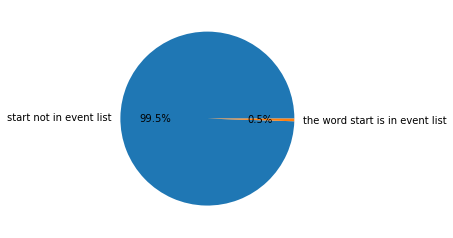

<Figure size 2160x2160 with 0 Axes>

In [83]:

plt.pie(journey_expanded.event_list_contains_start.value_counts(), labels=['start not in event list', 'the word start is in event list'], autopct='%1.1f%%')
plt.figure(figsize=(30,30))

<Figure size 2160x2160 with 0 Axes>

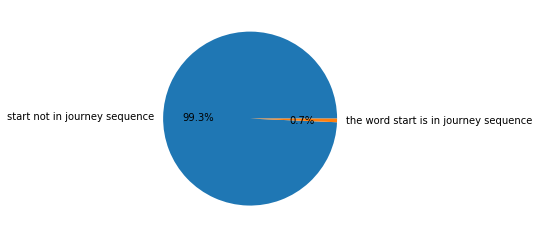

<Figure size 2160x2160 with 0 Axes>

In [84]:

plt.pie(journey_expanded.page_seq_contains_start.value_counts(), labels=['start not in journey sequence', 'the word start is in journey sequence'], autopct='%1.1f%%')
plt.figure(figsize=(30,30))

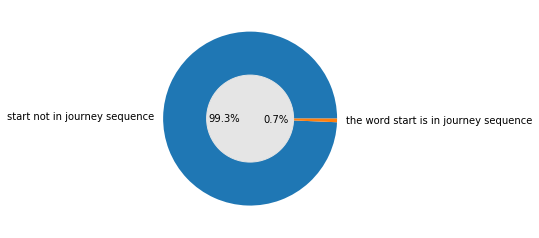

In [85]:

plt.pie(journey_expanded.page_seq_contains_start.value_counts(), labels=['start not in journey sequence', 'the word start is in journey sequence'], autopct='%1.1f%%', pctdistance=0.3)

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

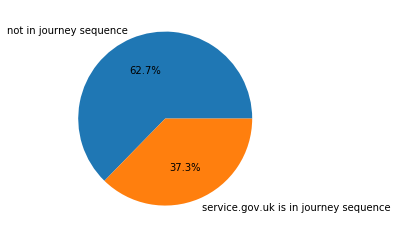

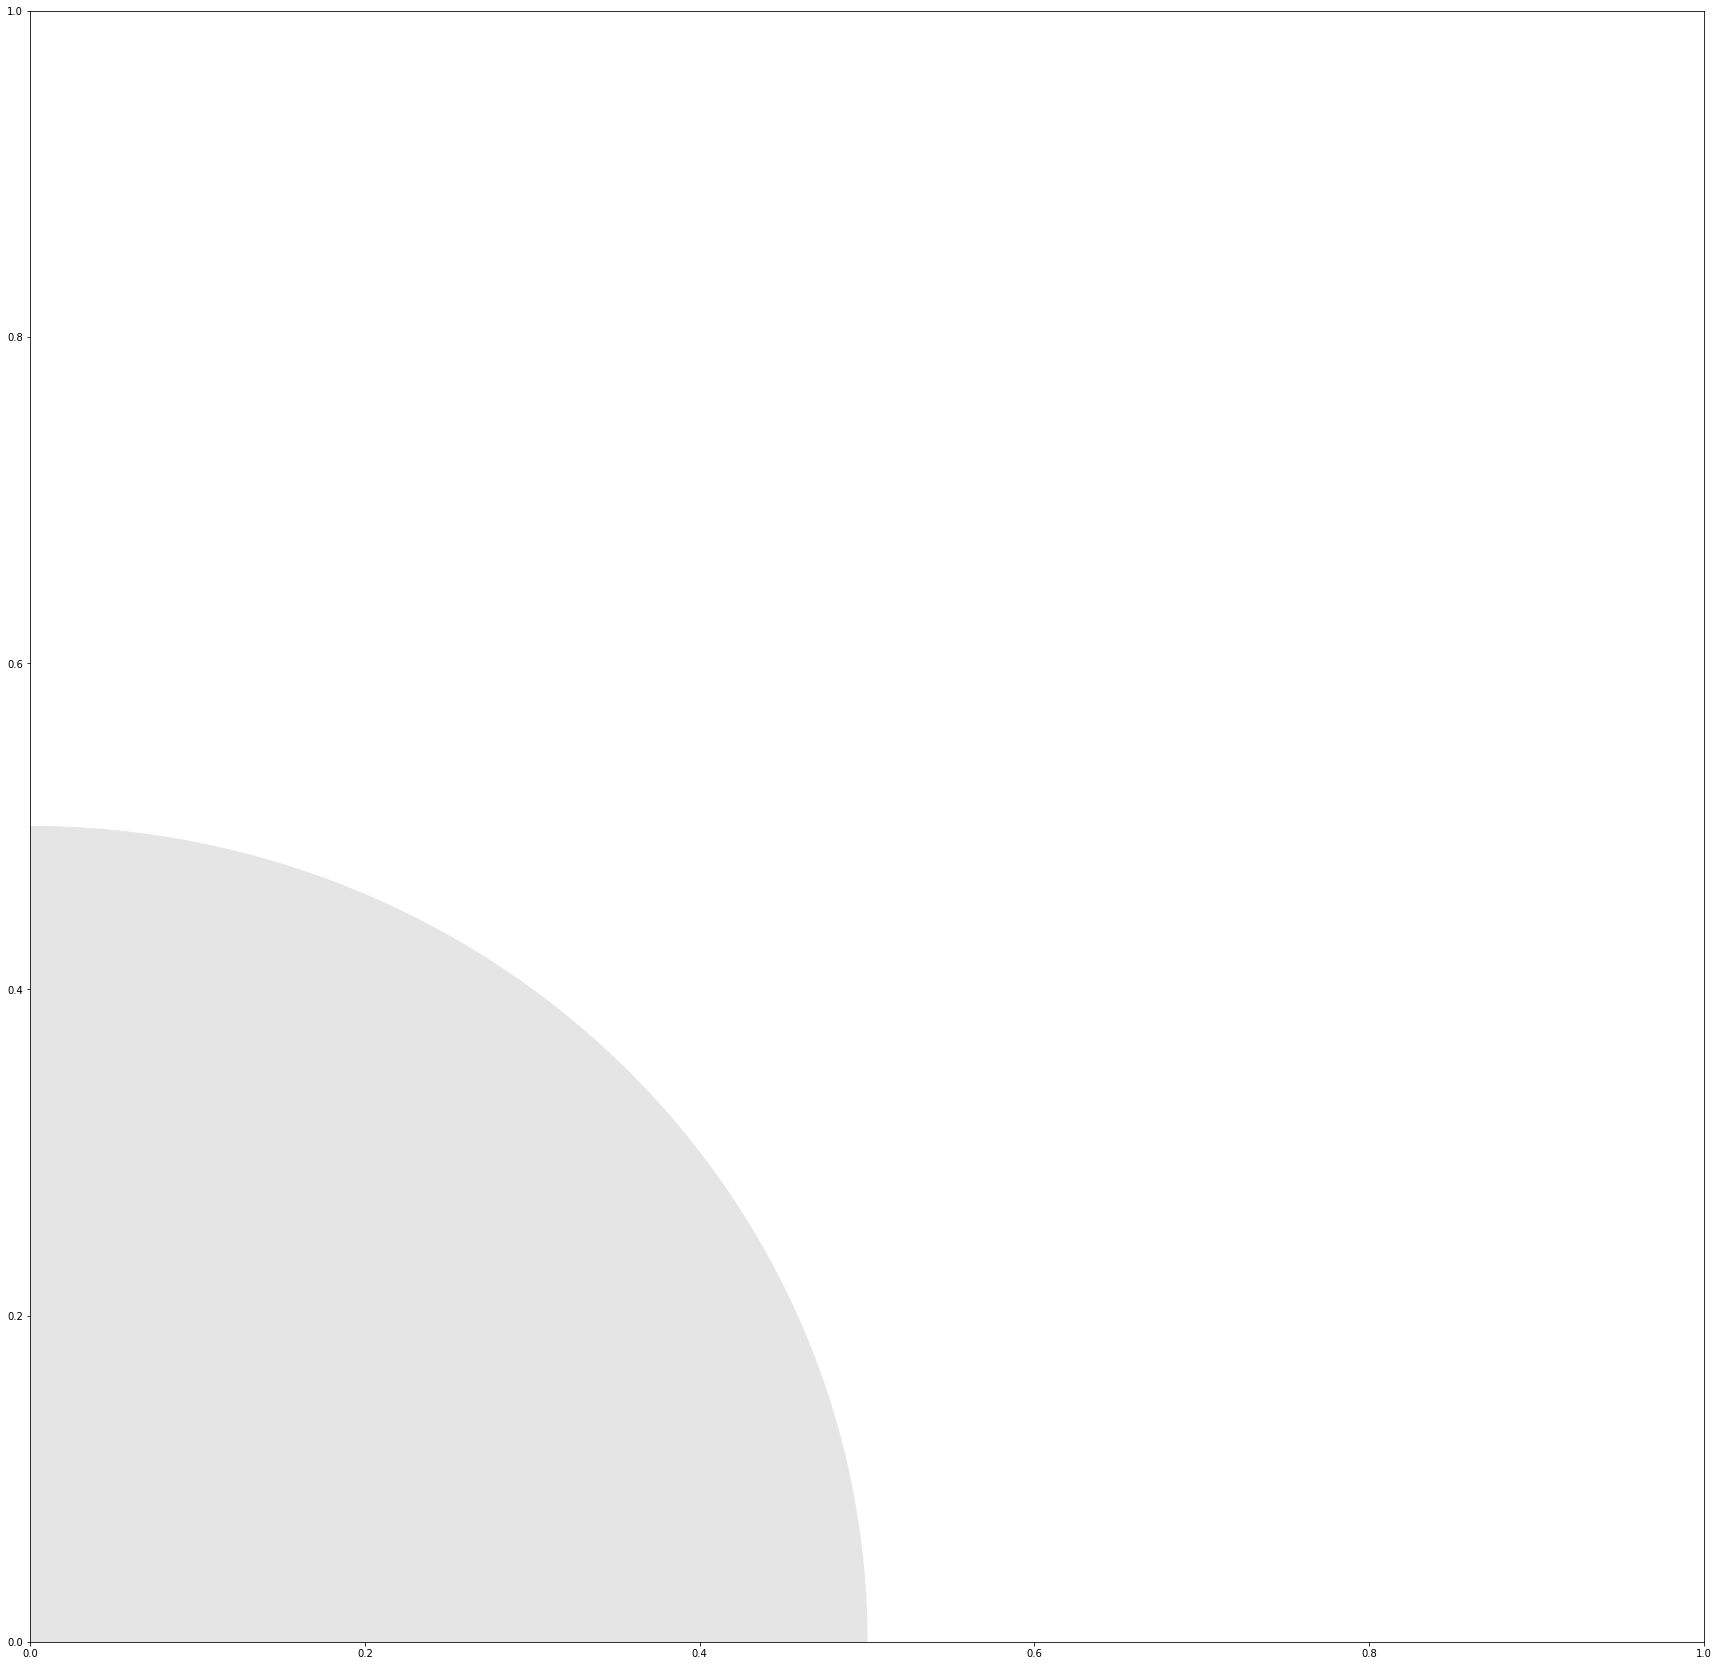

In [86]:

plt.pie(journey_expanded['page_seq_contains_service.gov.uk'].value_counts(), labels=['not in journey sequence', 'service.gov.uk is in journey sequence'], autopct='%1.1f%%')
plt.figure(figsize=(30,30))

# add a circle at the center
my_circle=plt.Circle( (0,0), 0.5, color='#E5E5E5')
p=plt.gcf()
p.gca().add_artist(my_circle)

### End page

In [87]:
journeys['final_page'].nunique()

14517

In [88]:
journeys.shape

(46799, 31)

#### most frequent end pages

In [89]:
journey_expanded.groupby('final_page').size().describe()

count     14517.000000
mean        480.969346
std        8080.920868
min           1.000000
25%           1.000000
50%           2.000000
75%          54.000000
max      560033.000000
dtype: float64

In [90]:
journey_expanded.groupby('final_page').size().sort_values(ascending=False)

final_page
/sign-in-universal-credit                                                                                                                                                                             560033
/vehicle-tax                                                                                                                                                                                          457414
/get-information-about-a-company                                                                                                                                                                      310703
/check-vehicle-tax                                                                                                                                                                                    273741
/log-in-register-hmrc-online-services                                                                                                                                    

Text(0.5, 0, 'Number of journeys where page is final')

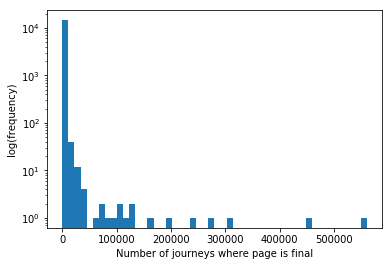

In [91]:
ax = journey_expanded.groupby('final_page').size().hist(bins=50, grid=False)
ax.set_yscale('log')
ax.set_ylabel("log(frequency)")
ax.set_xlabel("Number of journeys where page is final")

In [92]:
journey_expanded.groupby('final_page').size().sort_values(ascending=False).iloc[250:300]

final_page
/tax-relief-for-employees/uniforms-work-clothing-and-tools                                                                              3182
/log-in-file-self-assessment-tax-return/register-if-youre-self-employed                                                                 3167
/renew-adult-passport                                                                                                                   3155
/tell-hmrc-change-address                                                                                                               3154
/paye-online                                                                                                                            3147
/fishing-licences/buy-a-fishing-licence                                                                                                 3093
/government/publications/sex-and-relationship-education                                                                                 3092
/g

#### Most number of 'ways' of getting there

In [93]:
print("On average there are {} journeys per exit page; ways of getting there".format(journeys.shape[0]/journeys['final_page'].nunique()))

On average there are 3.2237376868499 journeys per exit page; ways of getting there


In [94]:
print(250/560033*100)
print(338/246283*100)
print(91/36262*100)
print(418/2632*100)


0.044640226558077825
0.1372404916295481
0.25095140918868236
15.881458966565349


In [95]:
print(560033/250)
print(246283/338)
print(36262/91)
print(2632/418)


2240.132
728.6479289940828
398.4835164835165
6.29665071770335


In [96]:
unique_page_sequences = journeys.drop_duplicates('Page_Seq_NL')

In [97]:
unique_page_sequences.groupby('final_page').size().describe()

count    14517.000000
mean         2.492802
std          8.518748
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        418.000000
dtype: float64

In [98]:
unique_page_sequences.groupby('final_page').size().sort_values(ascending=False)

final_page
/                                                                                                                                                                                                         418
/log-in-register-hmrc-online-services                                                                                                                                                                     338
/vehicle-tax                                                                                                                                                                                              336
/sign-in-universal-credit                                                                                                                                                                                 250
/get-information-about-a-company                                                                                                                                     

In [99]:
unique_page_sequences.groupby('final_page').size().sort_values(ascending=False)[['final_page']=='/electoral-register/view-electoral-register']

418

In [100]:
pd.set_option('display.max_colwidth', -1)
unique_page_sequences[unique_page_sequences['final_page']=='/vehicle-tax'].head()

,Sequence,Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence,Event_List,num_event_cats,Event_cats_agg,...,page_seq_contains_start,page_seq_contains_service.gov.uk,contains_search_regex,contains_search_n,final_page,final_interaction,desktop,mobile,other_device,more_desktop
0,/check-vehicle-tax<<PAGE<:<NULL<:<NULL>>/check-vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,2272,"[('mobile', 1589), ('desktop', 547), ('tablet', 136)]","[('20181031', 725), ('20181029', 486), ('20181102', 710), ('20181104', 351)]","[('/check-vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/check-vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk'), ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk')]","['/check-vehicle-tax', '/vehicle-tax']",/check-vehicle-tax>>/vehicle-tax,"[('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicleenquiry.service.gov.uk'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicletax.service.gov.uk')]",2,"[('PAGE_NULL', 2), ('External Link Clicked', 2)]",...,0,1,0,0,/vehicle-tax,EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,547,1589,136,0
20,/sold-bought-vehicle<<PAGE<:<NULL<:<NULL>>/sold-bought-vehicle/y<<PAGE<:<NULL<:<NULL>>/sold-bought-vehicle/y/yes<<PAGE<:<NULL<:<NULL>>/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade<<PAGE<:<NULL<:<NULL>>/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade<<EVENT<:<Simple Smart Answer<:<Completed>>/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade<<EVENT<:<External Link Clicked<:<https://www.buysellvehicle.service.gov.uk/buy-motor-trade/setup-trade-details>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,444,"[('desktop', 424), ('tablet', 12), ('mobile', 8)]","[('20181031', 188), ('20181029', 109), ('20181102', 122), ('20181104', 25)]","[('/sold-bought-vehicle', 'PAGE<:<NULL<:<NULL'), ('/sold-bought-vehicle/y', 'PAGE<:<NULL<:<NULL'), ('/sold-bought-vehicle/y/yes', 'PAGE<:<NULL<:<NULL'), ('/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade', 'PAGE<:<NULL<:<NULL'), ('/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade', 'EVENT<:<Simple Smart Answer<:<Completed'), ('/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade', 'EVENT<:<External Link Clicked<:<https://www.buysellvehicle.service.gov.uk/buy-motor-trade/setup-trade-details'), ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'), ('/vehicle-tax', 'EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk')]","['/sold-bought-vehicle', '/sold-bought-vehicle/y', '/sold-bought-vehicle/y/yes', '/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade', '/vehicle-tax']",/sold-bought-vehicle>>/sold-bought-vehicle/y>>/sold-bought-vehicle/y/yes>>/sold-bought-vehicle/y/yes/sold-a-vehicle-out-of-the-trade>>/vehicle-tax,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('Simple Smart Answer', 'Completed'), ('External Link Clicked', 'https://www.buysellvehicle.service.gov.uk/buy-motor-trade/setup-trade-details'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.vehicletax.service.gov.uk')]",3,"[('PAGE_NULL', 5), ('Simple Smart Answer', 1), ('External Link Clicked', 2)]",...,0,1,0,0,/vehicle-tax,EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk,424,8,12,1
66,/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk>>/vehicle-tax<<EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk>>/vehicle-tax<<PAGE<:<NULL<:<NULL>>/vehicle-tax<<EVE

In [101]:
unique_page_sequences.groupby('final_page').size().describe()

count    14517.000000
mean     2.492802    
std      8.518748    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      2.000000    
max      418.000000  
dtype: float64

In [102]:
journeys['final_page_type'] = 'other'
journeys.loc[journeys['final_page'].str.contains('/government/publications/', 'final_page_type')] = 'government_publication'
journeys.loc[journeys['final_page'].str.contains('log-in', 'final_page_type')] = 'login'
journeys.loc[journeys['final_page'].str.contains('sign-in', 'final_page_type')] = 'login'
journeys.loc[journeys['final_page'].str.contains('login', 'final_page_type')] = 'login'
journeys.loc[journeys['final_page'].str.contains('check', 'final_page_type')] = 'check'
journeys.loc[journeys['final_page'].str.contains('apply', 'final_page_type')] = 'apply'
journeys.loc[journeys['final_page'].str.contains('contact', 'final_page_type')] = 'contact/enquiries'
journeys.loc[journeys['final_page'].str.contains('enquiries', 'final_page_type')] = 'contact/enquiries'
journeys.loc[journeys['final_page'].str.contains(r'get-.*-information.*', 'final_page_type')] = 'get_information'
journeys.loc[journeys['final_page'].str.contains('send', 'final_page_type')] = 'send'
journeys.loc[journeys['final_page'].str.contains('find', 'final_page_type')] = 'find'
journeys.loc[journeys['final_page'].str.contains('calculat', 'final_page_type')] = 'calculate/calculator'
journeys.loc[journeys['final_page'].str.contains('order', 'final_page_type')] = 'order'
journeys.loc[journeys['final_page'].str.contains('manage', 'final_page_type')] = 'manage'
journeys.loc[journeys['final_page'].str.contains('update', 'final_page_type')] = 'update'
journeys.loc[journeys['final_page'].str.contains('eligibility', 'final_page_type')] = 'eligibility'
journeys.loc[journeys['final_page'].str.contains('estimate', 'final_page_type')] = 'estimate'
journeys.loc[journeys['final_page'].str.contains('renew', 'final_page_type')] = 'renew'
journeys.loc[journeys['final_page'].str.contains('pay', 'final_page_type')] = 'pay'
journeys.loc[journeys['final_page'].str.contains('claim', 'final_page_type')] = 'claim'
journeys.loc[journeys['final_page'].str.contains('change', 'final_page_type')] = 'change'

In [103]:
journeys.groupby('final_page_type').size()

final_page_type
apply                     2385 
calculate/calculator      1442 
change                    1072 
check                     3048 
claim                     830  
contact/enquiries         1514 
eligibility               478  
estimate                  54   
find                      748  
get_information           171  
government_publication    7177 
login                     2495 
manage                    330  
order                     141  
other                     22236
pay                       1929 
renew                     263  
send                      292  
update                    194  
dtype: int64

(           final_page_type  Page_Seq_NL    percent
 7   estimate                54           0.115387 
 13  order                   141          0.301288 
 9   get_information         171          0.365392 
 18  update                  194          0.414539 
 16  renew                   263          0.561978 
 17  send                    292          0.623945 
 12  manage                  330          0.705143 
 6   eligibility             478          1.021389 
 8   find                    748          1.598325 
 4   claim                   830          1.773542 
 2   change                  1072         2.290647 
 1   calculate/calculator    1442         3.081262 
 5   contact/enquiries       1514         3.235112 
 15  pay                     1929         4.121883 
 0   apply                   2385         5.096263 
 11  login                   2495         5.331310 
 3   check                   3048         6.512960 
 10  government_publication  7177         15.335798
 14  other  

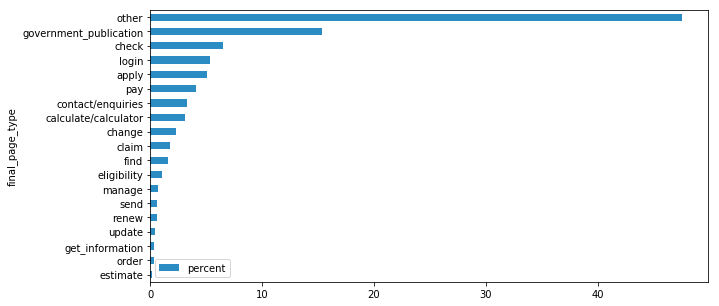

In [104]:
groupby_percent(journeys, 'final_page_type', 'Page_Seq_NL')

#### Final interaction with GOV.UK

In [105]:
# pd.set_option('display.max_colwidth', -1)
# journeys[journeys.final_interaction.str.contains('start')]

In [106]:
# journeys['final_interaction_type'] = journeys.final_interaction.str.extract(r'<:<(.*)<:<', expand=False)

In [107]:
# journeys['final_external_link'] = journeys.final_interaction.str.extract(r'EVENT<:<External Link Clicked<:(.*)', expand=False)

In [108]:
# journeys['exit_to_assessed_service'] = np.where(journeys['final_external_link'].str.contains(r'.*service.gov.uk.*', na=False), 1, 0)

In [109]:
# journeys['exit_to_assessed_service'].value_counts(normalize=True)

In [110]:
#make a smaller copy of data with only 2 cols ready to make it really looooong
slim = journeys[['Occurrences','exit_to_assessed_service']].copy()
#repeat rows for each occurrence
journey_expanded2 =  slim.loc[slim.index.repeat(slim['Occurrences'])]

KeyError: "['exit_to_assessed_service'] not in index"

In [ ]:
journey_expanded2['exit_to_assessed_service'].value_counts(normalize=True)

In [ ]:
plt.pie(journey_expanded2['exit_to_assessed_service'].value_counts(), labels=['did not exit to an assessed service', 'exited to an assessed service'], autopct='%1.1f%%')

In [ ]:
journeys['final_external_link_service'] = np.where(journeys.final_interaction.str.contains(r'<External Link Clicked<:(.*)', expand=False)

In [ ]:
groupby_percent(journeys, 'final_interaction_type', 'PageSequence', figsize=(5, 10))

In [ ]:
journeys.groupby('final_interaction_type').size().sort_values(ascending=False)

In [ ]:
print(journeys[journeys['final_interaction']=='PAGE<:<NULL<:<NULL'].shape)

print("{} out of {} ({}%) journeys ended in a page hit".format(journeys[journeys['final_interaction']=='PAGE<:<NULL<:<NULL'].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction']=='PAGE<:<NULL<:<NULL'].shape[0]/journeys.shape[0]*100))

In [ ]:
print(journeys[journeys['final_interaction'].str.startswith('EVENT<:<External Link Clicked')].shape)

print("{} out of {} ({}%) journeys ended in an external link clicked".format(journeys[journeys['final_interaction'].str.startswith('EVENT<:<External Link Clicked')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.startswith('EVENT<:<External Link Clicked')].shape[0]/journeys.shape[0]*100))

In [ ]:
print(journeys[journeys['final_interaction'].str.startswith('EVENT<:<External Link Clicked')].shape)

print("{} out of {} ({}%) journeys ended in an specialist external link clicked".format(journeys[journeys['final_interaction'].str.startswith('EVENT<:<Specialist-external-link')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.startswith('EVENT<:<Specialist-external-link')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in aSpecialist-external-link".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<Specialist-external-link')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<Specialist-external-link')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in an download link clicked".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<Download Link Clicked')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<Download Link Clicked')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in a  contents clicked".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<contentsClicked<')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<contentsClicked<')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in a breadcrumbClicked".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<breadcrumbClicked<')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<breadcrumbClicked<')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in a JavaScript Error".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<JavaScript Error<')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<JavaScript Error<')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in a Simple Smart Answer".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<Simple Smart Answer<')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<Simple Smart Answer<')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in a Smart Answer".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<Smart Answer<')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<Smart Answer<')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in a social media".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<social media<')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<social media<')].shape[0]/journeys.shape[0]*100))

In [ ]:
print("{} out of {} ({}%) journeys ended in yesNoFeedbackForm".format(journeys[journeys['final_interaction'].str.contains('EVENT<:<yesNoFeedbackForm<')].shape[0], 
                                                        journeys.shape[0],
                                                        journeys[journeys['final_interaction'].str.contains('EVENT<:<yesNoFeedbackForm<')].shape[0]/journeys.shape[0]*100))